In [1]:
project = None
output = None

## Helper class for reading data from CellSketch projects

In [2]:
import z5py
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import os
from pathlib import Path

import numpy as np
import pandas
import z5py


class Cell:
    def __init__(self, path, linestyle='-'):
        self.file = z5py.File(str(path))
        self.name = Path(path).name.rstrip('.n5')
        self.path = path
        self.linestyle = linestyle

    def contains(self, volume_name):
        return self.name + '_' + volume_name in self.file
        
    def read_volume(self, volume_name):
        if volume_name is None:
            return None
        return np.array(self.file[(self.name + '_' + volume_name)])

    def read_volume_from_group(self, group, volume_name):
        if volume_name is None:
            return None
        return np.array(self.file[group][(self.name + '_' + volume_name)])

    def read_individual_table(self, labelmap_name):
        return self._read_table('analysis' + os.sep + self.name + '_' + labelmap_name + '_individual.csv')

    def read_overall_table(self, labelmap_name):
        return self._read_table('analysis' + os.sep + self.name + '_' + labelmap_name + '.csv')

    def _read_table(cell, table_name):
        return pandas.read_table(os.path.join(cell.path, table_name), delimiter=',')

    def read_distance_map(self, name):
        return self.read_volume_from_group("analysis", name + "_distance_map")

## Helper methods for plotting

In [3]:
text_connected = 'assoc'
text_not_connected = 'not assoc'
color_connected = '#ff7254'
color_not_connected = '#616163'
column_connected = 'connected to microtubules'

def histogram(ax_left, ax_right, data, kws):
    ax_left.hist(data, histtype="stepfilled", color=cell_color, weights=np.ones(len(data)) / len(data),
                 **kws)
    # cummulative plot
    ax_right.hist(data, histtype="step", cumulative=True, linestyle="dotted", color="#FF0000",
                  weights=np.ones(len(data)) / len(data), **kws)


def generate_plot_with_percentage(ax):
    ax_right = ax.twinx()
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax_right.yaxis.set_major_formatter(PercentFormatter(1))
    ax_right.tick_params(axis='y', labelcolor="#FF0000")
    ax_right.set_ylim([0, 1])
    return ax_right


def distances_filtered(distance_map, mask_in, masks_out):
    mask = mask_in > 0
    if masks_out is not None:
        for mask_out in masks_out:
            mask = mask & (mask_out == 0)
    return np.array(distance_map[mask])  

def violin_plot(ax, table, column):
    table['dummy'] = 0
    sns.violinplot(y="dummy", x=column, data=table, orient='h', inner=None,
                   color=cell_color, ax=ax)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))
    old_len_collections = len(ax.collections)
    sns.stripplot(y="dummy", x=column, data=table, ax=ax, orient='h', color=cell_color,
                  size=3)
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel("")
    ax.get_yaxis().set_ticks([])

    
def violin_plot_divided_by_mt_connection(ax, table, column):
    table['dummy'] = 0
    sns.violinplot(data=table, x='dummy', y=column, hue=column_connected, split=True,
                   palette=(color_not_connected, color_connected), ax=ax)
    ax.legend(handles=ax.legend_.legend_handles, labels=[text_not_connected, text_connected])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel("")
    ax.get_xaxis().set_ticks([])

def histogram_divided_by_mt_connection(ax, table, column, kws):
    granules_size_connected = column[table[column_connected] == True]
    granules_size_not_connected = column[table[column_connected] == False]
    num_connected = len(granules_size_connected)
    num_not_connected = len(granules_size_not_connected)
    ax.hist([granules_size_connected, granules_size_not_connected], label=[text_connected, text_not_connected],
            color=[color_connected, color_not_connected],
            weights=[np.ones(num_connected) / num_connected, np.ones(num_not_connected) / num_not_connected],
            **kws)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
def render_and_save(fig, title):
    fig.suptitle(title)
    plt.tight_layout()
    if output:
        plt.savefig(str(Path(output).joinpath(title.replace(" ", "_") + ".svg")))
    plt.show()
    plt.close(fig)

## Input data

In [4]:
cell_color = '#edb380'
color_random = '#000000'

In [5]:
cell = Cell(project)    
pixel_to_um = cell.file.attrs['pixelToUM']
if output:
    Path(output).mkdir(parents=True, exist_ok=True)
    print("Saving plots to %s" % output)

Saving plots to /home/deschmi/Development/album/collabs/betaseg/mycell.n5/plots


## Test if CellSketch data is conform to demo dataset
The following sections will only run if the CellSketch dataset contains certain masks and labels. In case you are working with your own dataset or if the labels and masks are named differently, adjust the naming in the examples below to make them run successfully. 

In [6]:
if not cell.contains('microtubules') or not cell.contains('granules') or not cell.contains('membrane') or not cell.contains('nucleus') or not cell.contains('golgi') or not cell.contains('microtubules') or not cell.contains('centrioles'):
    assert False, "The CellSketch project doesn't include the same keys as the demo project provided with the CellSketch protocol, therefore the exemplary jupyter notebook for generating plots needs to be adjusted to the project."

## Secretory granules

In [7]:
table_granules_individual = cell.read_individual_table('granules')
table_granules_overall = cell.read_overall_table('granules')

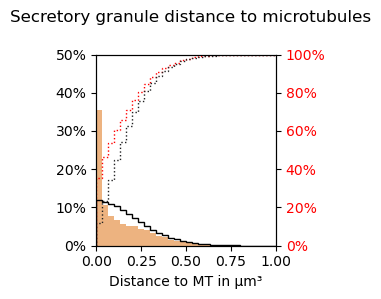

In [8]:
# Plot distance to MT statistics
fig, ax_left = plt.subplots(figsize=(3, 3))
ax_right = generate_plot_with_percentage(ax_left)

# get data from table
granules_distance_to_MT = table_granules_individual['distance to microtubules in um']
max_x = 1; max_y = 0.5

# histogram
kws = dict(range=(0, max_x*2), bins=60)
histogram(ax_left, ax_right, granules_distance_to_MT, kws)

# get random distribution data
distance_map = cell.read_distance_map("microtubules")
mask_in = cell.read_volume("membrane")
masks_out = [cell.read_volume("microtubules"), cell.read_volume("nucleus")]
data_random = distances_filtered(distance_map, mask_in, masks_out) * pixel_to_um
# subtract mean radius of granules, since pixels considered to be part of a granule would have that distance in mean
mean_volume = table_granules_overall['mean size in micrometer^3'][0]
mean_radius = (3. / (4. * np.pi) * mean_volume) ** (1. / 3.)
# data_random = np.clip(data_random - mean_radius, 0, None)
data_random -= mean_radius
data_random = data_random[data_random >= 0]
# plot random distribution
ax_left.hist(data_random, histtype="step", label="random distribution", color=color_random,
             weights=np.ones(len(data_random)) / len(data_random), **kws)
ax_right.hist(data_random, histtype="step", cumulative=True, linestyle="dotted", color="#212122",
              weights=np.ones(len(data_random)) / len(data_random), **kws)

ax_left.set_xlim([0, max_x])
ax_left.set_ylim([0, max_y])
ax_left.set_xlabel('Distance to MT in μm³')

render_and_save(fig, 'Secretory granule distance to microtubules')

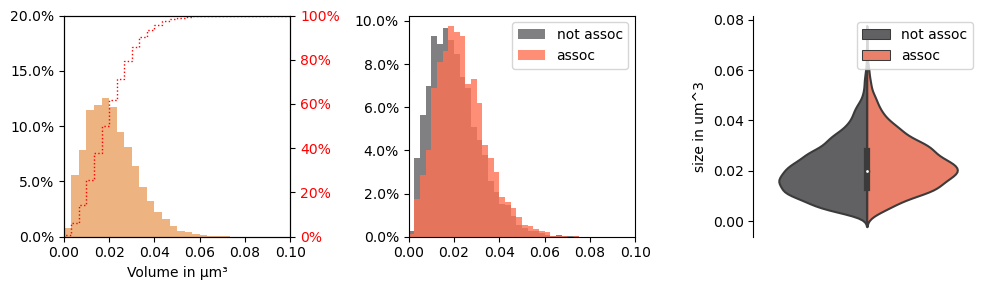

In [9]:
# Plot volume
column = 'size in um^3'
max_x = 0.1; max_y = 0.2

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_granules_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Volume in μm³')

# histogram comparing granules separated by whether they are connected to MTs or not
kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=80, range=(0, max_x * 2))
histogram_divided_by_mt_connection(ax=ax1, table=table_granules_individual, column=column, kws=kws)
ax1.set_xlim([0, max_x])
ax1.legend()

# violin plot
violin_plot_divided_by_mt_connection(ax2, table_granules_individual, column)
render_and_save(fig, 'Secretory granule volume')

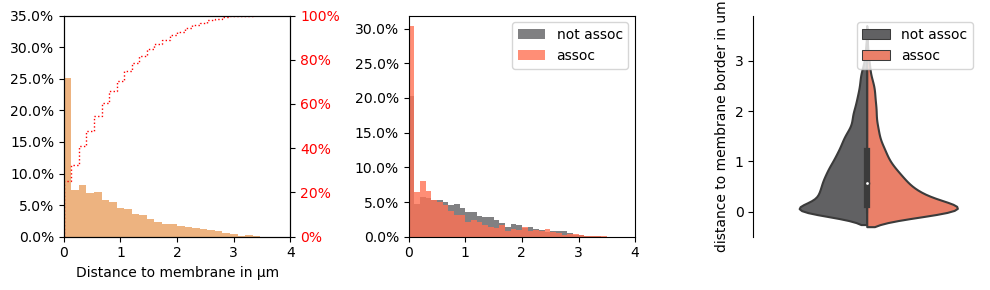

In [10]:
# Plot distance to membrane

column = 'distance to membrane border in um'
min_x = 0; max_x = 4; max_y = 0.35

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_granules_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance to membrane in μm')

# histogram comparing granules separated by whether they are connected to MTs or not
kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=80, range=(0, max_x * 2))
histogram_divided_by_mt_connection(ax=ax1, table=table_granules_individual, column=column, kws=kws)
ax1.set_xlim([0, max_x])
ax1.legend()

# violin plot
violin_plot_divided_by_mt_connection(ax2, table_granules_individual, column)

render_and_save(fig, 'Secretory granule distance to membrane')

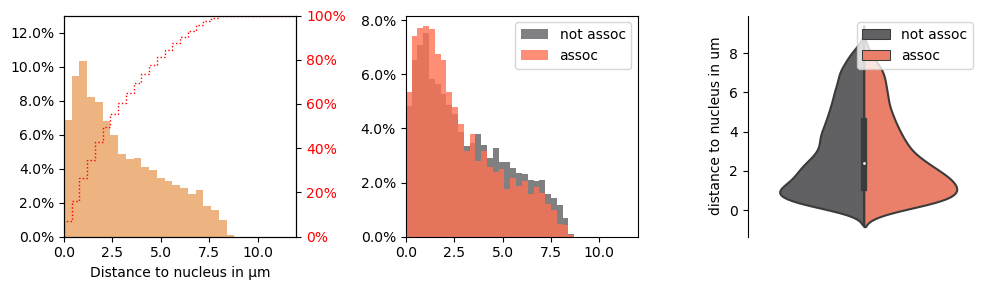

In [11]:
# Plot distance to nucleus

column = 'distance to nucleus in um'
max_x = 12; max_y = 0.13

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_granules_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance to nucleus in μm')

# histogram comparing granules separated by whether they are connected to MTs or not
kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=80, range=(0, max_x * 2))
histogram_divided_by_mt_connection(ax=ax1, table=table_granules_individual, column=column, kws=kws)
ax1.set_xlim([0, max_x])
ax1.legend()

# violin plot
violin_plot_divided_by_mt_connection(ax2, table_granules_individual, column)

render_and_save(fig, 'Secretory granule distance to nucleus')

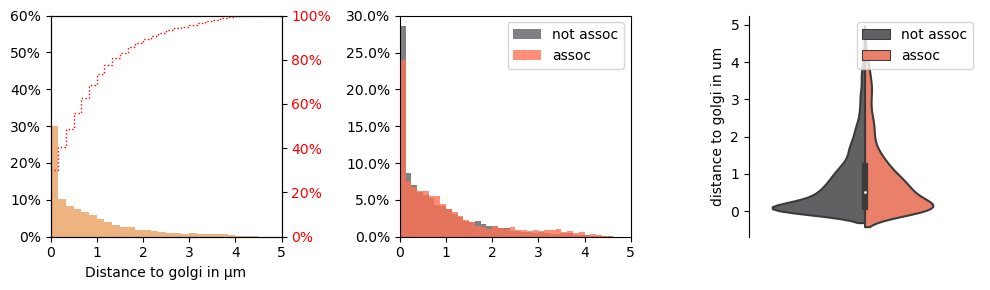

In [12]:
# Plot distance to golgi

column = 'distance to golgi in um'
max_x = 5; max_y = 0.6

fig1, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_granules_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance to golgi in μm')

# histogram comparing granules separated by whether they are connected to MTs or not
kws = dict(histtype="stepfilled", alpha=0.8, linewidth=2, bins=80, range=(0, max_x * 2))
histogram_divided_by_mt_connection(ax=ax1, table=table_granules_individual, column=column, kws=kws)
ax1.set_xlim([0, max_x])
ax1.legend()

# violin plot
violin_plot_divided_by_mt_connection(ax2, table_granules_individual, column)

render_and_save(fig, 'Secretory granule distance to golgi')

## Microtubules

In [13]:
table_mt_individual = cell.read_individual_table('microtubules')
table_mt_overall = cell.read_overall_table('microtubules')

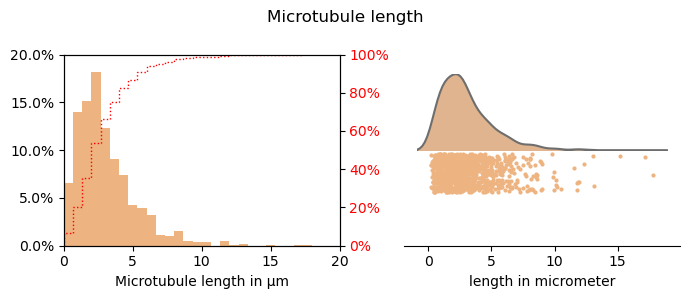

In [14]:
column = 'length in micrometer'
max_x = 20; max_y = 0.2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Microtubule length in μm')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Microtubule length')

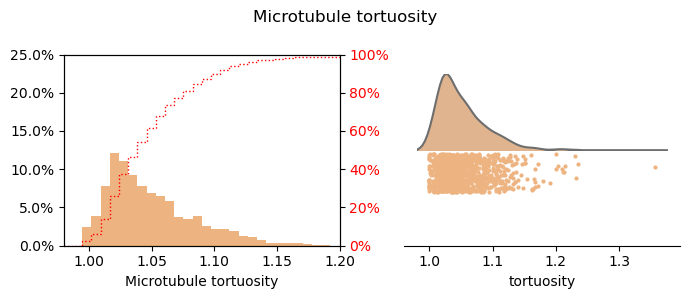

In [15]:
column = 'tortuosity'
min_x = 0.98; max_x = 1.2; max_y = 0.25

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(min_x, max_x + (max_x-min_x)), bins=60))
ax0.set_xlim([min_x, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Microtubule tortuosity')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Microtubule tortuosity')

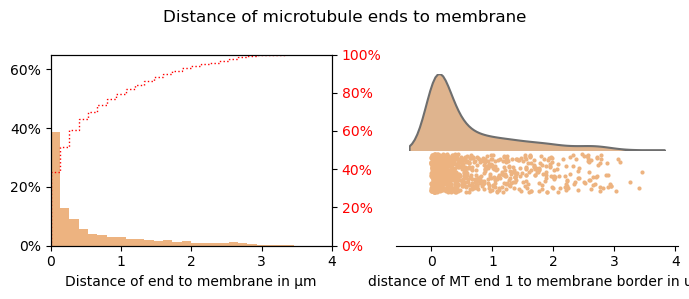

In [16]:
column = 'distance of MT end 1 to membrane border in um'
max_x = 4; max_y = 0.65

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance of end to membrane in μm')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Distance of microtubule ends to membrane')

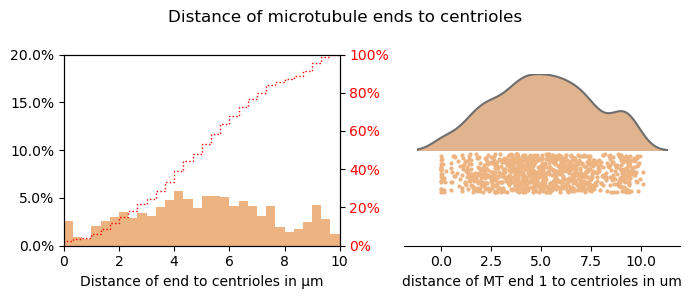

In [17]:
column = 'distance of MT end 1 to centrioles in um'
max_x = 10; max_y = 0.2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance of end to centrioles in μm')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Distance of microtubule ends to centrioles')

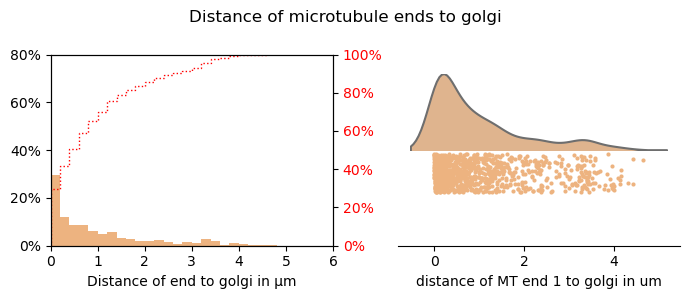

In [18]:
column = 'distance of MT end 1 to golgi in um'

max_x = 6; max_y = 0.8

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance of end to golgi in μm')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Distance of microtubule ends to golgi')

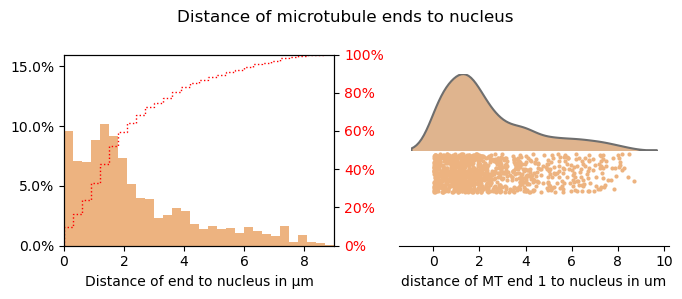

In [19]:
column = 'distance of MT end 1 to nucleus in um'
max_x = 9; max_y = 0.16

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# histogram
ax_right = generate_plot_with_percentage(ax0)
column = table_mt_individual[column]
histogram(ax0, ax_right, column, kws=dict(range=(0, max_x * 2), bins=60))
ax0.set_xlim([0, max_x])
ax0.set_ylim([0, max_y])
ax0.set_xlabel('Distance of end to nucleus in μm')

# violin plot
violin_plot(ax1, table_mt_individual, column)

render_and_save(fig, 'Distance of microtubule ends to nucleus')